In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
try:
    from astropy.cosmology import FlatLambdaCDM
    from astropy import units as u
    ASTROPY_AVAILABLE = True
except ImportError:
    ASTROPY_AVAILABLE = False
    print("Warning: astropy not available. Reference solutions will be skipped.")

class FriedmannIntegrator:
    """
    Step-by-step Friedmann equation integrator for n-body simulations
    """
    def __init__(self, omega_m_func, omega_lambda=None, omega_k=None, h0=70.0, method='RK4'):
        """
        Initialize the Friedmann integrator
        
        Parameters:
        -----------
        omega_m_func : callable
            Function that takes scale factor 'a' as input and returns Omega_m(a)
        omega_lambda : float, optional
            Dark energy density parameter
        omega_k : float, optional  
            Curvature density parameter
        h0 : float, default=70.0
            Hubble constant in km/s/Mpc
        method : str, default='RK4'
            Integration method: 'RK4', 'RK2', 'Euler', 'adaptive_RK4'
        """
        self.omega_m_func = omega_m_func
        self.omega_lambda = omega_lambda
        self.omega_k = omega_k
        self.h0 = h0
        self.H0_inv_Gyr = h0 * 1.022e-3  # Convert to 1/Gyr
        self.method = method
        
        # Current state
        self.current_a = None
        self.current_t = None
        self.current_H = None
        self.current_omega_m = None
        
        # For adaptive stepping
        self.target_accuracy = 1e-8
        self.min_dt = 1e-6
        self.max_dt = 0.1
        
    def _get_density_params(self, a):
        """Get all density parameters at scale factor a"""
        omega_m_current = self.omega_m_func(a)
        
        if self.omega_lambda is None and self.omega_k is None:
            omega_lambda_current = 1.0 - omega_m_current
            omega_k_current = 0.0
        elif self.omega_lambda is None:
            omega_lambda_current = 1.0 - omega_m_current - self.omega_k
            omega_k_current = self.omega_k
        elif self.omega_k is None:
            omega_lambda_current = self.omega_lambda
            omega_k_current = 1.0 - omega_m_current - self.omega_lambda
        else:
            omega_lambda_current = self.omega_lambda
            omega_k_current = self.omega_k
            
        return omega_m_current, omega_lambda_current, omega_k_current
    
    def _friedmann_derivative(self, a, t):
        """
        Calculate da/dt from Friedmann equation
        """
        if a <= 0:
            return 0
            
        omega_m, omega_lambda, omega_k = self._get_density_params(a)
        
        # Friedmann equation: H^2 = H0^2 * [Omega_m/a^3 + Omega_lambda + Omega_k/a^2]
        H_squared = self.H0_inv_Gyr**2 * (omega_m/a**3 + omega_lambda + omega_k/a**2)
        
        if H_squared < 0:
            return 0
            
        H = np.sqrt(H_squared)
        
        # da/dt = H * a
        return H * a
    
    def initialize(self, a_initial, t_initial=0.0):
        """
        Initialize the integrator state
        """
        self.current_a = a_initial
        self.current_t = t_initial
        
        # Calculate initial values
        omega_m, omega_lambda, omega_k = self._get_density_params(a_initial)
        self.current_omega_m = omega_m
        
        H_squared = self.H0_inv_Gyr**2 * (omega_m/a_initial**3 + omega_lambda + omega_k/a_initial**2)
        self.current_H = np.sqrt(max(0, H_squared))
        
    def step(self, dt):
        """
        Take a single integration step
        
        Parameters:
        -----------
        dt : float
            Time step in Gyr
            
        Returns:
        --------
        dict : Current state after the step
        """
        if self.current_a is None:
            raise ValueError("Integrator not initialized. Call initialize() first.")
            
        if self.method == 'Euler':
            new_a = self._step_euler(dt)
        elif self.method == 'RK2':
            new_a = self._step_rk2(dt)
        elif self.method == 'RK4':
            new_a = self._step_rk4(dt)
        elif self.method == 'adaptive_RK4':
            new_a = self._step_adaptive_rk4(dt)
        else:
            raise ValueError(f"Unknown integration method: {self.method}")
            
        # Update state
        self.current_a = new_a
        self.current_t += dt
        
        # Recalculate derived quantities
        omega_m, omega_lambda, omega_k = self._get_density_params(self.current_a)
        self.current_omega_m = omega_m
        
        H_squared = self.H0_inv_Gyr**2 * (omega_m/self.current_a**3 + omega_lambda + omega_k/self.current_a**2)
        self.current_H = np.sqrt(max(0, H_squared))
        
        return self.get_state()
    
    def _step_euler(self, dt):
        """Euler method step"""
        dadt = self._friedmann_derivative(self.current_a, self.current_t)
        return self.current_a + dt * dadt
    
    def _step_rk2(self, dt):
        """2nd-order Runge-Kutta step"""
        a = self.current_a
        t = self.current_t
        
        k1 = self._friedmann_derivative(a, t)
        k2 = self._friedmann_derivative(a + 0.5*dt*k1, t + 0.5*dt)
        
        return a + dt * k2
    
    def _step_rk4(self, dt):
        """4th-order Runge-Kutta step"""
        a = self.current_a
        t = self.current_t
        
        k1 = self._friedmann_derivative(a, t)
        k2 = self._friedmann_derivative(a + 0.5*dt*k1, t + 0.5*dt)
        k3 = self._friedmann_derivative(a + 0.5*dt*k2, t + 0.5*dt)
        k4 = self._friedmann_derivative(a + dt*k3, t + dt)
        
        return a + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    
    def _step_adaptive_rk4(self, dt):
        """Adaptive RK4 with error control"""
        # Take one full step
        a_full = self._step_rk4(dt)
        
        # Take two half steps
        a_temp = self.current_a
        a_half1 = self._step_rk4_single(a_temp, self.current_t, dt/2)
        a_half2 = self._step_rk4_single(a_half1, self.current_t + dt/2, dt/2)
        
        # Estimate error
        error = abs(a_full - a_half2) / max(abs(a_full), abs(a_half2), 1e-10)
        
        # For now, just return the more accurate half-step result
        # In a full implementation, you'd adjust dt based on error
        return a_half2
    
    def _step_rk4_single(self, a, t, dt):
        """Single RK4 step for adaptive method"""
        k1 = self._friedmann_derivative(a, t)
        k2 = self._friedmann_derivative(a + 0.5*dt*k1, t + 0.5*dt)
        k3 = self._friedmann_derivative(a + 0.5*dt*k2, t + 0.5*dt)
        k4 = self._friedmann_derivative(a + dt*k3, t + dt)
        
        return a + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    
    def get_state(self):
        """Get current state of the integrator"""
        return {
            'a': self.current_a,
            't': self.current_t,
            'H': self.current_H,
            'omega_m': self.current_omega_m
        }
    
    def get_hubble_time(self):
        """Get current Hubble time H^-1 in Gyr"""
        return 1.0 / self.current_H if self.current_H > 0 else np.inf
    
    def get_critical_density(self):
        """Get critical density in units of ρ_crit,0 * a^-3"""
        return self.current_H**2 / self.H0_inv_Gyr**2
    
    def suggest_timestep(self, accuracy_factor=0.01):
        """
        Suggest a reasonable timestep based on current Hubble time
        
        Parameters:
        -----------
        accuracy_factor : float, default=0.01
            Fraction of Hubble time to use as timestep
            
        Returns:
        --------
        float : Suggested timestep in Gyr
        """
        hubble_time = self.get_hubble_time()
        suggested_dt = accuracy_factor * hubble_time
        
        # Clamp to reasonable limits
        return max(self.min_dt, min(suggested_dt, self.max_dt))

def solve_friedmann_variable_omega(omega_m_func, omega_lambda=None, omega_k=None, 
                                 a_initial=1e-3, a_final=2.0, n_points=1000, 
                                 method='RK45', h0=70.0):
    """
    Solve the Friedmann equation with time-varying matter density parameter Omega_m.
    
    The Friedmann equation: (da/dt)^2 = H0^2 * [Omega_m(a)/a + Omega_lambda*a^2 + Omega_k]
    
    Parameters:
    -----------
    omega_m_func : callable
        Function that takes scale factor 'a' as input and returns Omega_m(a)
        Should be of the form: omega_m_func(a) -> float
    omega_lambda : float, optional
        Dark energy density parameter. If None, calculated from closure relation
    omega_k : float, optional  
        Curvature density parameter. If None, calculated from closure relation
    a_initial : float, default=1e-3
        Initial scale factor (should be small for early universe)
    a_final : float, default=2.0
        Final scale factor to integrate to
    n_points : int, default=1000
        Number of points in the solution
    method : str, default='RK45'
        Integration method for solve_ivp
    h0 : float, default=70.0
        Hubble constant in km/s/Mpc
        
    Returns:
    --------
    dict : Solution dictionary containing:
        - 'a': array of scale factors
        - 't': array of cosmic time (in Gyr)
        - 'H': array of Hubble parameter values
        - 'omega_m': array of Omega_m values at each scale factor
        - 'success': bool indicating if integration was successful
    """
    
    # Convert H0 to inverse Gyr units
    H0_inv_Gyr = h0 * 1.022e-3  # km/s/Mpc to 1/Gyr conversion
    
    def friedmann_ode(t, y):
        """
        ODE system for the Friedmann equation
        y[0] = a (scale factor)
        y[1] = da/dt
        """
        a = y[0]
        if a <= 0:
            return [0, 0]
            
        # Get current Omega_m value
        omega_m_current = omega_m_func(a)
        
        # Calculate other density parameters if not provided
        if omega_lambda is None and omega_k is None:
            # Assume flat universe: Omega_m + Omega_lambda = 1
            omega_lambda_current = 1.0 - omega_m_current
            omega_k_current = 0.0
        elif omega_lambda is None:
            omega_lambda_current = 1.0 - omega_m_current - omega_k
            omega_k_current = omega_k
        elif omega_k is None:
            omega_lambda_current = omega_lambda
            omega_k_current = 1.0 - omega_m_current - omega_lambda
        else:
            omega_lambda_current = omega_lambda
            omega_k_current = omega_k
        
        # Friedmann equation: H^2 = H0^2 * [Omega_m/a^3 + Omega_lambda + Omega_k/a^2]
        H_squared = H0_inv_Gyr**2 * (omega_m_current/a**3 + omega_lambda_current + omega_k_current/a**2)
        
        if H_squared < 0:
            return [0, 0]
            
        H = np.sqrt(H_squared)
        
        # da/dt = H * a
        dadt = H * a
        
        # d(da/dt)/dt = d(H*a)/dt
        # For simplicity, we'll use the fact that d^2a/dt^2 can be derived from the acceleration equation
        # but since we're solving first-order system, we return [da/dt, d(da/dt)/dt]
        # We'll solve this as a first-order system by setting da/dt = H*a
        
        return [dadt, 0]  # Second component will be recalculated
    
    def friedmann_ode_simple(t, y):
        """
        Simplified ODE: da/dt = H(a) * a
        """
        a = y[0]
        if a <= 0:
            return [0]
            
        omega_m_current = omega_m_func(a)
        
        if omega_lambda is None and omega_k is None:
            omega_lambda_current = 1.0 - omega_m_current
            omega_k_current = 0.0
        elif omega_lambda is None:
            omega_lambda_current = 1.0 - omega_m_current - omega_k
            omega_k_current = omega_k
        elif omega_k is None:
            omega_lambda_current = omega_lambda
            omega_k_current = 1.0 - omega_m_current - omega_lambda
        else:
            omega_lambda_current = omega_lambda
            omega_k_current = omega_k
        
        H_squared = H0_inv_Gyr**2 * (omega_m_current/a**3 + omega_lambda_current + omega_k_current/a**2)
        
        if H_squared < 0:
            return [0]
            
        H = np.sqrt(H_squared)
        dadt = H * a
        
        return [dadt]
    
    # Set up integration
    t_span = (0, 50)  # Large time span, will stop when a reaches a_final
    y0 = [a_initial]
    
    # Event function to stop integration at desired final scale factor
    def stop_at_final_a(t, y):
        return y[0] - a_final
    
    stop_at_final_a.terminal = True
    stop_at_final_a.direction = 1
    
    # Solve the ODE
    try:
        sol = solve_ivp(friedmann_ode_simple, t_span, y0, 
                       method=method, dense_output=True, 
                       events=stop_at_final_a,
                       max_step=0.01, rtol=1e-8, atol=1e-10)
        
        if not sol.success:
            return {'success': False, 'message': sol.message}
        
        # Extract solution
        t_solution = sol.t
        a_solution = sol.y[0]
        
        # Interpolate to get evenly spaced points in scale factor
        a_interp = np.linspace(a_initial, a_solution[-1], n_points)
        t_interp = np.interp(a_interp, a_solution, t_solution)
        
        # Calculate Hubble parameter and Omega_m at each point
        H_interp = np.zeros_like(a_interp)
        omega_m_interp = np.zeros_like(a_interp)
        
        for i, a in enumerate(a_interp):
            omega_m_current = omega_m_func(a)
            omega_m_interp[i] = omega_m_current
            
            if omega_lambda is None and omega_k is None:
                omega_lambda_current = 1.0 - omega_m_current
                omega_k_current = 0.0
            elif omega_lambda is None:
                omega_lambda_current = 1.0 - omega_m_current - omega_k
                omega_k_current = omega_k
            elif omega_k is None:
                omega_lambda_current = omega_lambda
                omega_k_current = 1.0 - omega_m_current - omega_lambda
            else:
                omega_lambda_current = omega_lambda
                omega_k_current = omega_k
            
            H_squared = H0_inv_Gyr**2 * (omega_m_current/a**3 + omega_lambda_current + omega_k_current/a**2)
            H_interp[i] = np.sqrt(max(0, H_squared))
        
        return {
            'a': a_interp,
            't': t_interp,
            'H': H_interp,
            'omega_m': omega_m_interp,
            'success': True
        }
        
    except Exception as e:
        return {'success': False, 'message': str(e)}


# Example usage and test functions
def get_astropy_reference(omega_m=0.3, omega_lambda=0.7, h0=70.0, a_min=1e-3, a_max=2.0, n_points=1000):
    """
    Get reference solution from astropy cosmology for comparison
    """
    if not ASTROPY_AVAILABLE:
        return None
        
    # Create astropy cosmology object
    cosmo = FlatLambdaCDM(H0=h0 * u.km / u.s / u.Mpc, Om0=omega_m)
    
    # Scale factor array
    a_array = np.linspace(a_min, a_max, n_points)
    
    # Convert scale factor to redshift
    z_array = 1.0/a_array - 1.0
    
    # Calculate age of universe at each redshift
    t_array = cosmo.age(z_array).to(u.Gyr).value
    
    # Calculate Hubble parameter at each redshift
    H_array = cosmo.H(z_array).to(u.km / u.s / u.Mpc).value
    
    # Convert to 1/Gyr units for consistency
    H_array_Gyr = H_array * 1.022e-3  # km/s/Mpc to 1/Gyr
    
    return {
        'a': a_array,
        't': t_array,
        'H': H_array_Gyr,
        'omega_m': np.full_like(a_array, omega_m)
    }


def example_constant_omega_m():
    """Example with constant Omega_m and astropy comparison"""
    omega_m_val = 0.3
    omega_lambda_val = 0.7
    h0_val = 70.0
    
    def omega_m_const(a):
        return omega_m_val
    
    result = solve_friedmann_variable_omega(omega_m_const, omega_lambda=omega_lambda_val, h0=h0_val)
    
    # Get astropy reference solution
    astropy_ref = get_astropy_reference(omega_m=omega_m_val, omega_lambda=omega_lambda_val, 
                                       h0=h0_val, a_min=result['a'][0], a_max=result['a'][-1])
    
    if result['success']:
        plt.figure(figsize=(15, 10))
        
        # Scale factor evolution
        plt.subplot(2, 3, 1)
        plt.plot(result['t'], result['a'], 'b-', label='Custom Solver', linewidth=2)
        if astropy_ref:
            plt.plot(astropy_ref['t'], astropy_ref['a'], 'r--', label='Astropy Reference', linewidth=2)
        plt.xlabel('Time (Gyr)')
        plt.ylabel('Scale Factor a')
        plt.title('Scale Factor Evolution')
        plt.legend()
        plt.grid(True)
        
        # Hubble parameter evolution
        plt.subplot(2, 3, 2)
        plt.plot(result['t'], result['H'], 'b-', label='Custom Solver', linewidth=2)
        if astropy_ref:
            plt.plot(astropy_ref['t'], astropy_ref['H'], 'r--', label='Astropy Reference', linewidth=2)
        plt.xlabel('Time (Gyr)')
        plt.ylabel('Hubble Parameter (1/Gyr)')
        plt.title('Hubble Parameter Evolution')
        plt.legend()
        plt.grid(True)
        
        # Matter density parameter
        plt.subplot(2, 3, 3)
        plt.plot(result['a'], result['omega_m'], 'b-', label='Custom Solver', linewidth=2)
        if astropy_ref:
            plt.plot(astropy_ref['a'], astropy_ref['omega_m'], 'r--', label='Astropy Reference', linewidth=2)
        plt.xlabel('Scale Factor a')
        plt.ylabel('Omega_m')
        plt.title('Matter Density Parameter')
        plt.legend()
        plt.grid(True)
        
        # H vs a (log-log)
        plt.subplot(2, 3, 4)
        plt.loglog(result['a'], result['H'], 'b-', label='Custom Solver', linewidth=2)
        if astropy_ref:
            plt.loglog(astropy_ref['a'], astropy_ref['H'], 'r--', label='Astropy Reference', linewidth=2)
        plt.xlabel('Scale Factor a')
        plt.ylabel('Hubble Parameter (1/Gyr)')
        plt.title('H vs a (log-log)')
        plt.legend()
        plt.grid(True)
        
        # Relative error in scale factor
        plt.subplot(2, 3, 5)
        if astropy_ref:
            # Interpolate astropy solution to match our time grid
            a_astropy_interp = np.interp(result['t'], astropy_ref['t'], astropy_ref['a'])
            rel_error_a = np.abs(result['a'] - a_astropy_interp) / a_astropy_interp * 100
            plt.semilogy(result['t'], rel_error_a, 'g-', linewidth=2)
            plt.xlabel('Time (Gyr)')
            plt.ylabel('Relative Error in a (%)')
            plt.title('Scale Factor Relative Error')
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Astropy not available', transform=plt.gca().transAxes, 
                    ha='center', va='center', fontsize=12)
        
        # Relative error in Hubble parameter
        plt.subplot(2, 3, 6)
        if astropy_ref:
            # Interpolate astropy solution to match our time grid
            H_astropy_interp = np.interp(result['t'], astropy_ref['t'], astropy_ref['H'])
            rel_error_H = np.abs(result['H'] - H_astropy_interp) / H_astropy_interp * 100
            plt.semilogy(result['t'], rel_error_H, 'g-', linewidth=2)
            plt.xlabel('Time (Gyr)')
            plt.ylabel('Relative Error in H (%)')
            plt.title('Hubble Parameter Relative Error')
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Astropy not available', transform=plt.gca().transAxes, 
                    ha='center', va='center', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison statistics
        if astropy_ref:
            print("\nComparison with Astropy Reference:")
            print(f"Age of universe at a=1:")
            age_custom = np.interp(1.0, result['a'], result['t'])
            age_astropy = np.interp(1.0, astropy_ref['a'], astropy_ref['t'])
            print(f"  Custom solver: {age_custom:.3f} Gyr")
            print(f"  Astropy:       {age_astropy:.3f} Gyr")
            print(f"  Relative error: {abs(age_custom - age_astropy)/age_astropy*100:.6f}%")
            
            print(f"\nHubble parameter at a=1:")
            H_custom = np.interp(1.0, result['a'], result['H'])
            H_astropy = np.interp(1.0, astropy_ref['a'], astropy_ref['H'])
            print(f"  Custom solver: {H_custom:.6f} Gyr⁻¹")
            print(f"  Astropy:       {H_astropy:.6f} Gyr⁻¹")
            print(f"  Relative error: {abs(H_custom - H_astropy)/H_astropy*100:.6f}%")
        
        return result
    else:
        print(f"Integration failed: {result['message']}")
        return None


def example_stepwise_integration():
    """Example showing step-by-step integration for n-body simulation"""
    
    # Define cosmological parameters
    def omega_m_const(a):
        return 0.3
    
    # Create integrator
    integrator = FriedmannIntegrator(omega_m_const, omega_lambda=0.7, method='RK4')
    
    # Initialize
    a_initial = 1e-3
    integrator.initialize(a_initial)
    
    # Storage for results
    times = [integrator.current_t]
    scale_factors = [integrator.current_a]
    hubble_params = [integrator.current_H]
    omega_m_values = [integrator.current_omega_m]
    
    # Integration loop (similar to what you'd do in n-body simulation)
    target_time = 15.0  # Gyr
    
    print("Starting stepwise integration...")
    print(f"Initial state: a={integrator.current_a:.6f}, t={integrator.current_t:.3f} Gyr, H={integrator.current_H:.6f} Gyr⁻¹")
    
    step_count = 0
    while integrator.current_t < target_time and integrator.current_a < 2.0:
        # Get suggested timestep (this would be coordinated with your n-body timestep)
        dt = integrator.suggest_timestep(accuracy_factor=0.01)
        
        # Take a step
        state = integrator.step(dt)
        
        # Store results
        times.append(state['t'])
        scale_factors.append(state['a'])
        hubble_params.append(state['H'])
        omega_m_values.append(state['omega_m'])
        
        step_count += 1
        
        # Print progress occasionally
        if step_count % 1000 == 0:
            print(f"Step {step_count}: a={state['a']:.6f}, t={state['t']:.3f} Gyr, H={state['H']:.6f} Gyr⁻¹")
    
    print(f"Integration completed after {step_count} steps")
    print(f"Final state: a={integrator.current_a:.6f}, t={integrator.current_t:.3f} Gyr, H={integrator.current_H:.6f} Gyr⁻¹")
    
    # Convert to arrays
    times = np.array(times)
    scale_factors = np.array(scale_factors)
    hubble_params = np.array(hubble_params)
    omega_m_values = np.array(omega_m_values)
    
    # Compare with reference solutions
    result_stepwise = {
        'a': scale_factors,
        't': times,
        'H': hubble_params,
        'omega_m': omega_m_values,
        'success': True
    }
    
    # Get reference solutions
    result_reference = solve_friedmann_variable_omega(omega_m_const, omega_lambda=0.7, 
                                                    a_initial=a_initial, a_final=scale_factors[-1])
    
    astropy_ref = get_astropy_reference(omega_m=0.3, omega_lambda=0.7, h0=70.0, 
                                       a_min=a_initial, a_max=scale_factors[-1])
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(times, scale_factors, 'b-', label='Stepwise RK4', linewidth=2)
    plt.plot(result_reference['t'], result_reference['a'], 'g--', label='solve_ivp Reference', linewidth=2)
    if astropy_ref:
        plt.plot(astropy_ref['t'], astropy_ref['a'], 'r:', label='Astropy Reference', linewidth=2)
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Scale Factor a')
    plt.title('Scale Factor Evolution Comparison')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 3, 2)
    plt.plot(times, hubble_params, 'b-', label='Stepwise RK4', linewidth=2)
    plt.plot(result_reference['t'], result_reference['H'], 'g--', label='solve_ivp Reference', linewidth=2)
    if astropy_ref:
        plt.plot(astropy_ref['t'], astropy_ref['H'], 'r:', label='Astropy Reference', linewidth=2)
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Hubble Parameter (1/Gyr)')
    plt.title('Hubble Parameter Evolution')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 3, 3)
    plt.loglog(scale_factors, hubble_params, 'b-', label='Stepwise RK4', linewidth=2)
    plt.loglog(result_reference['a'], result_reference['H'], 'g--', label='solve_ivp Reference', linewidth=2)
    if astropy_ref:
        plt.loglog(astropy_ref['a'], astropy_ref['H'], 'r:', label='Astropy Reference', linewidth=2)
    plt.xlabel('Scale Factor a')
    plt.ylabel('Hubble Parameter (1/Gyr)')
    plt.title('H vs a (log-log)')
    plt.legend()
    plt.grid(True)
    
    # Error analysis
    plt.subplot(2, 3, 4)
    if astropy_ref:
        a_astropy_interp = np.interp(times, astropy_ref['t'], astropy_ref['a'])
        rel_error_a = np.abs(scale_factors - a_astropy_interp) / a_astropy_interp * 100
        plt.semilogy(times, rel_error_a, 'b-', linewidth=2, label='vs Astropy')
    
    # Compare with solve_ivp
    a_ref_interp = np.interp(times, result_reference['t'], result_reference['a'])
    rel_error_ref = np.abs(scale_factors - a_ref_interp) / a_ref_interp * 100
    plt.semilogy(times, rel_error_ref, 'g--', linewidth=2, label='vs solve_ivp')
    
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Relative Error in a (%)')
    plt.title('Scale Factor Relative Error')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 3, 5)
    # Plot timestep evolution
    dt_array = np.diff(times)
    plt.semilogy(times[1:], dt_array, 'b-', linewidth=2)
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Timestep (Gyr)')
    plt.title('Adaptive Timestep Evolution')
    plt.grid(True)
    
    plt.subplot(2, 3, 6)
    # Plot Hubble time evolution
    hubble_time = 1.0 / hubble_params
    plt.plot(times, hubble_time, 'b-', linewidth=2)
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Hubble Time (Gyr)')
    plt.title('Hubble Time Evolution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nIntegration Statistics:")
    print(f"Total steps: {step_count}")
    print(f"Average timestep: {np.mean(np.diff(times)):.6f} Gyr")
    print(f"Min timestep: {np.min(np.diff(times)):.6f} Gyr")
    print(f"Max timestep: {np.max(np.diff(times)):.6f} Gyr")
    
    if astropy_ref:
        print(f"\nAccuracy vs Astropy:")
        print(f"Max relative error in a: {np.max(rel_error_a):.6f}%")
        print(f"RMS relative error in a: {np.sqrt(np.mean(rel_error_a**2)):.6f}%")
    
    print(f"\nAccuracy vs solve_ivp:")
    print(f"Max relative error in a: {np.max(rel_error_ref):.6f}%")
    print(f"RMS relative error in a: {np.sqrt(np.mean(rel_error_ref**2)):.6f}%")
    
    return result_stepwise


def example_nbody_integration_pattern():
    """
    Example showing how to integrate this into an n-body simulation loop
    """
    print("\n" + "="*60)
    print("N-BODY SIMULATION INTEGRATION PATTERN")
    print("="*60)
    
    # This is pseudocode showing how you'd integrate cosmological evolution
    # into your n-body simulation
    
    code_example = '''
# In your n-body simulation setup:
def setup_cosmology():
    def omega_m_func(a):
        return 0.3  # or your custom function
    
    cosmo = FriedmannIntegrator(omega_m_func, omega_lambda=0.7, method='RK4')
    cosmo.initialize(a_initial=0.01)  # Start at z=99
    return cosmo

# In your main simulation loop:
def simulation_loop():
    cosmo = setup_cosmology()
    particles = initialize_particles()
    
    while simulation_not_finished:
        # 1. Get current cosmological parameters
        current_state = cosmo.get_state()
        a = current_state['a']
        H = current_state['H']
        
        # 2. Calculate appropriate timestep
        dt_cosmo = cosmo.suggest_timestep(accuracy_factor=0.01)
        dt_nbody = calculate_nbody_timestep(particles)
        dt = min(dt_cosmo, dt_nbody)
        
        # 3. Evolve particles with cosmological expansion
        # Convert to comoving coordinates if needed
        update_particle_positions(particles, dt, a, H)
        
        # 4. Step the cosmological background
        cosmo.step(dt)
        
        # 5. Apply cosmological corrections to forces/velocities
        apply_hubble_flow(particles, H)
        
        # 6. Your n-body physics here...
        calculate_forces(particles)
        integrate_equations_of_motion(particles, dt)
        
        # 7. Output/analysis
        if output_time:
            save_snapshot(particles, current_state)
    '''
    
    print(code_example)
    
    # Demonstrate actual integration with mock n-body timesteps
    def omega_m_func(a):
        return 0.3
    
    cosmo = FriedmannIntegrator(omega_m_func, omega_lambda=0.7, method='RK4')
    cosmo.initialize(a_initial=0.01)
    
    print("\\nSimulating coordinated timesteps:")
    print("Time(Gyr)  Scale Factor  Hubble(Gyr⁻¹)  Cosmo_dt(Gyr)  NBBody_dt(Gyr)  Used_dt(Gyr)")
    print("-" * 85)
    
    for i in range(20):
        state = cosmo.get_state()
        dt_cosmo = cosmo.suggest_timestep(0.01)
        dt_nbody = 0.005 * (1 + state['a'])  # Mock n-body timestep that grows with a
        dt_used = min(dt_cosmo, dt_nbody)
        
        print(f"{state['t']:8.3f}   {state['a']:10.6f}   {state['H']:11.6f}   {dt_cosmo:10.6f}   {dt_nbody:11.6f}   {dt_used:10.6f}")
        
        cosmo.step(dt_used)
        
        if state['a'] > 1.0:
            break
    
    return cosmo

Testing Friedmann equation solver with variable Omega_m...

1. Testing with constant Omega_m = 0.3 (with astropy comparison):


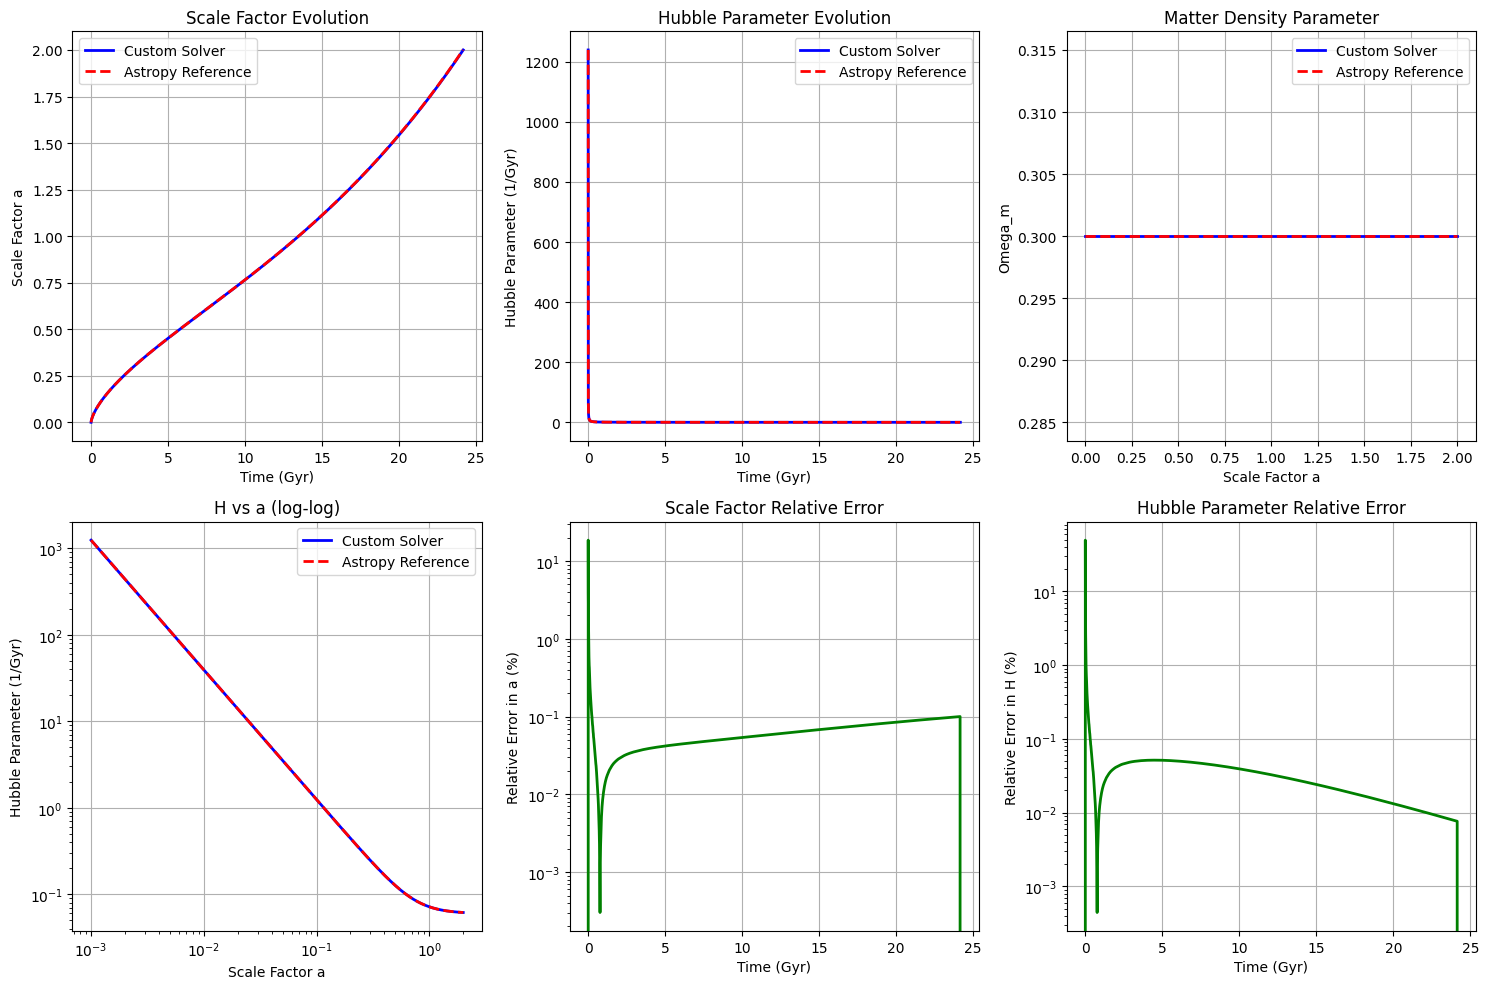


Comparison with Astropy Reference:
Age of universe at a=1:
  Custom solver: 13.476 Gyr
  Astropy:       13.467 Gyr
  Relative error: 0.065685%

Hubble parameter at a=1:
  Custom solver: 0.071540 Gyr⁻¹
  Astropy:       0.071540 Gyr⁻¹
  Relative error: 0.000000%

2. Testing stepwise integration for n-body simulations:
Starting stepwise integration...
Initial state: a=0.001000, t=0.000 Gyr, H=1239.109149 Gyr⁻¹
Integration completed after 721 steps
Final state: a=1.113607, t=15.014 Gyr, H=0.068515 Gyr⁻¹


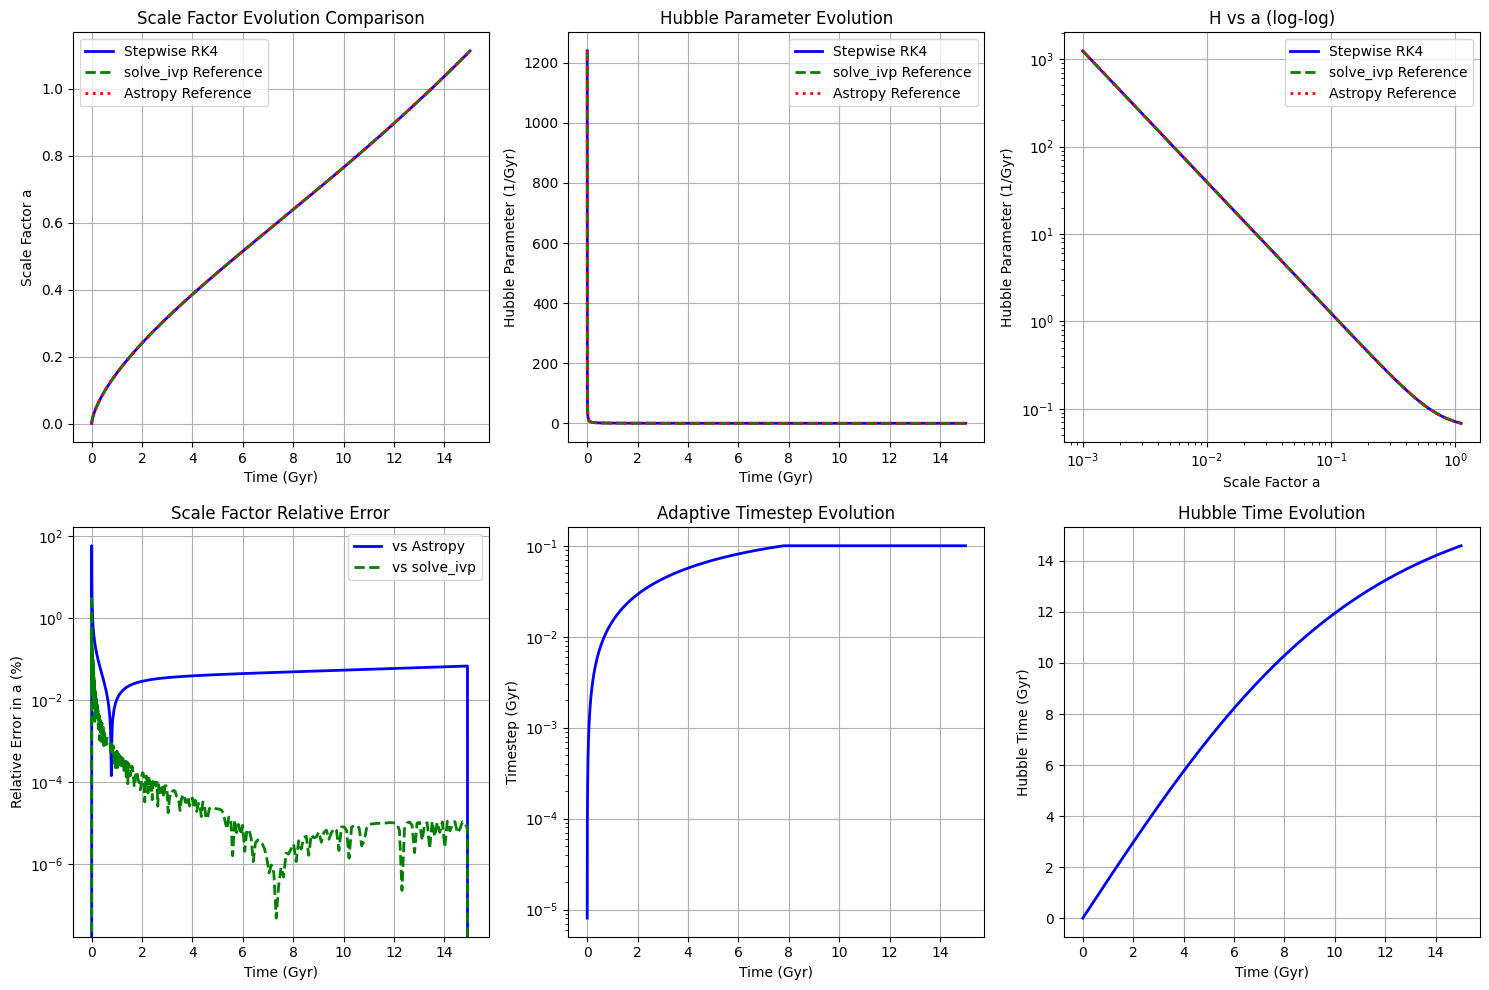


Integration Statistics:
Total steps: 721
Average timestep: 0.020824 Gyr
Min timestep: 0.000008 Gyr
Max timestep: 0.100000 Gyr

Accuracy vs Astropy:
Max relative error in a: 58.252966%
RMS relative error in a: 13.787789%

Accuracy vs solve_ivp:
Max relative error in a: 3.588724%
RMS relative error in a: 0.881338%

3. N-body simulation integration pattern:

N-BODY SIMULATION INTEGRATION PATTERN

# In your n-body simulation setup:
def setup_cosmology():
    def omega_m_func(a):
        return 0.3  # or your custom function
    
    cosmo = FriedmannIntegrator(omega_m_func, omega_lambda=0.7, method='RK4')
    cosmo.initialize(a_initial=0.01)  # Start at z=99
    return cosmo

# In your main simulation loop:
def simulation_loop():
    cosmo = setup_cosmology()
    particles = initialize_particles()
    
    while simulation_not_finished:
        # 1. Get current cosmological parameters
        current_state = cosmo.get_state()
        a = current_state['a']
        H = current_state['H']
 

In [2]:

print("Testing Friedmann equation solver with variable Omega_m...")

# Test with constant Omega_m and astropy comparison
print("\n1. Testing with constant Omega_m = 0.3 (with astropy comparison):")
result1 = example_constant_omega_m()

# Test stepwise integration for n-body simulations
print("\n2. Testing stepwise integration for n-body simulations:")
result_stepwise = example_stepwise_integration()

# Show n-body integration pattern
print("\n3. N-body simulation integration pattern:")
cosmo_final = example_nbody_integration_pattern()

if result1 and result1['success']:
    print(f"\\nBatch solver: Final time = {result1['t'][-1]:.2f} Gyr")
    print(f"Age of universe at a=1: {np.interp(1.0, result1['a'], result1['t']):.2f} Gyr")

if result_stepwise and result_stepwise['success']:
    print(f"\\nStepwise solver: Final time = {result_stepwise['t'][-1]:.2f} Gyr")
    print(f"Age of universe at a=1: {np.interp(1.0, result_stepwise['a'], result_stepwise['t']):.2f} Gyr")

# With Nbody2d

In [1]:
from __future__ import annotations
from dataclasses import dataclass
import numpy as np
from scipy.integrate import quad
import numba
import matplotlib.pyplot as plt

import sys
sys.path.append('.')
# Assuming cft.py is in the same directory or in the python path
try:
    import cft
except ImportError:
    print("Warning: 'cft' module not found. Please ensure it's in the python path.")
    # Create a dummy cft module for basic functionality if it's missing
    class DummyBox:
        def __init__(self, dim, N, L):
            self.dim = dim
            self.N = N
            self.L = L
            self.res = L / N
            self.shape = (N,) * dim
        @property
        def K(self):
            # A simplified K for the dummy module
            return np.fft.fftfreq(self.N, d=self.res) * 2 * np.pi

    class DummyPotential:
        def __call__(self, K):
            # A simplified potential for the dummy module
            return -1.0 / (np.sum(K**2, axis=0) + 1e-9)

    cft = type('cft', (), {'Box': DummyBox, 'Potential': DummyPotential})


from abc import ABC, abstractmethod
from typing import Generic, TypeVar, Callable, Tuple
from functools import partial

# --- Start of Merged FriedmannIntegrator from friedmann_solver3.py ---
class FriedmannIntegrator:
    """
    Step-by-step Friedmann equation integrator for n-body simulations
    """
    def __init__(self, omega_m_func, omega_lambda=None, omega_k=None, h0=70.0, method='RK4'):
        self.omega_m_func = omega_m_func
        self.omega_lambda = omega_lambda
        self.omega_k = omega_k
        self.h0 = h0
        self.H0_inv_Gyr = h0 * 1.022e-3  # Convert to 1/Gyr
        self.method = method
        
        self.current_a = None
        self.current_t = None
        self.current_H = None
        self.current_omega_m = None
        
    def _get_density_params(self, a):
        omega_m_current = self.omega_m_func(a)
        
        if self.omega_lambda is None and self.omega_k is None:
            omega_lambda_current = 1.0 - omega_m_current
            omega_k_current = 0.0
        elif self.omega_lambda is None:
            omega_lambda_current = 1.0 - omega_m_current - self.omega_k
            omega_k_current = self.omega_k
        elif self.omega_k is None:
            omega_lambda_current = self.omega_lambda
            omega_k_current = 1.0 - omega_m_current - self.omega_lambda
        else:
            omega_lambda_current = self.omega_lambda
            omega_k_current = self.omega_k
            
        return omega_m_current, omega_lambda_current, omega_k_current
    
    def _friedmann_derivative(self, a, t):
        if a <= 0: return 0
        omega_m, omega_lambda, omega_k = self._get_density_params(a)
        H_squared = self.H0_inv_Gyr**2 * (omega_m/a**3 + omega_lambda + omega_k/a**2)
        if H_squared < 0: return 0
        H = np.sqrt(H_squared)
        return H * a
    
    def initialize(self, a_initial, t_initial=0.0):
        self.current_a = a_initial
        self.current_t = t_initial
        omega_m, omega_lambda, omega_k = self._get_density_params(a_initial)
        self.current_omega_m = omega_m
        H_squared = self.H0_inv_Gyr**2 * (omega_m/a_initial**3 + omega_lambda + omega_k/a_initial**2)
        self.current_H = np.sqrt(max(0, H_squared))
        
    def step(self, dt):
        if self.current_a is None:
            raise ValueError("Integrator not initialized. Call initialize() first.")
        
        a = self.current_a
        t = self.current_t
        k1 = self._friedmann_derivative(a, t)
        k2 = self._friedmann_derivative(a + 0.5*dt*k1, t + 0.5*dt)
        k3 = self._friedmann_derivative(a + 0.5*dt*k2, t + 0.5*dt)
        k4 = self._friedmann_derivative(a + dt*k3, t + dt)
        new_a = a + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
            
        self.current_a = new_a
        self.current_t += dt
        omega_m, omega_lambda, omega_k = self._get_density_params(self.current_a)
        self.current_omega_m = omega_m
        H_squared = self.H0_inv_Gyr**2 * (omega_m/self.current_a**3 + omega_lambda + omega_k/self.current_a**2)
        self.current_H = np.sqrt(max(0, H_squared))
        
        return self.get_state()
    
    def get_state(self):
        return {'a': self.current_a, 't': self.current_t, 'H': self.current_H, 'omega_m': self.current_omega_m}

# --- End of Merged FriedmannIntegrator ---


@dataclass
class Cosmology:
    H0 : float
    OmegaM : float
    OmegaL : float

    @property
    def OmegaK(self):
        return 1 - self.OmegaM - self.OmegaL
    @property
    def G(self):
        return 3./2 * self.OmegaM * self.H0**2
        
    # This is the original, simple Friedmann solution
    def da_original(self, a):
        return self.H0 * a * np.sqrt(
                  self.OmegaL \
                + self.OmegaM * a**-3 \
                + self.OmegaK * a**-2)
    def growing_mode(self, a):
        if isinstance(a, np.ndarray):
            return np.array([self.growing_mode(b) for b in a])
        elif a <= 0.001:
            return a
        else:
            # Note: The original da() is used here as it's part of the initial condition generation
            return self.da_original(a)/a * quad(lambda b: self.da_original(b)**(-3), 0.00001, a)[0] + 0.00001

LCDM = Cosmology(68.0, 0.31, 0.69)
EdS = Cosmology(70.0, 1.0, 0.0)


@numba.jit
def md_cic_2d(shape: Tuple[int], pos: np.ndarray, tgt: np.ndarray):
    for i in range(len(pos)):
        idx0, idx1 = int(np.floor(pos[i,0])), int(np.floor(pos[i,1]))
        f0, f1     = pos[i,0] - idx0, pos[i,1] - idx1
        tgt[idx0 % shape[0], idx1 % shape[1]] += (1 - f0) * (1 - f1)
        tgt[(idx0 + 1) % shape[0], idx1 % shape[1]] += f0 * (1 - f1)
        tgt[idx0 % shape[0], (idx1 + 1) % shape[1]] += (1 - f0) * f1
        tgt[(idx0 + 1) % shape[0], (idx1 + 1) % shape[1]] += f0 * f1

class Interp2D:
    "Reasonably fast bilinear interpolation routine"
    def __init__(self, data):
        self.data = data
        self.shape = data.shape

    def __call__(self, x):
        X1 = np.floor(x).astype(int) % self.shape[0]
        X2 = (X1 + 1) % self.shape[0]
        Y1 = np.floor(x).astype(int) % self.shape[1]
        Y2 = (Y1 + 1) % self.shape[1]
        
        xm = x % 1.0
        xn = 1.0 - xm

        f1 = self.data[X1[:,0], Y1[:,1]]
        f2 = self.data[X2[:,0], Y1[:,1]]
        f3 = self.data[X1[:,0], Y2[:,1]]
        f4 = self.data[X2[:,0], Y2[:,1]]

        return  f1 * xn[:,0] * xn[:,1] + \
                f2 * xm[:,0] * xn[:,1] + \
                f3 * xn[:,0] * xm[:,1] + \
                f4 * xm[:,0] * xm[:,1]


def gradient_2nd_order(F, i):
    return   (1./12 * np.roll(F, -2, axis=i) - 2./3  * np.roll(F, -1, axis=i) \
           + 2./3  * np.roll(F,  1, axis=i) - 1./12 * np.roll(F,  2, axis=i))

Vector = TypeVar("Vector", bound=np.ndarray)

@dataclass
class State(Generic[Vector]):
    time : float
    position : Vector
    momentum : Vector

    def kick(self, dt: float, h: 'HamiltonianSystem[Vector]') -> State[Vector]:
        self.momentum += dt * h.momentumEquation(self)
        return self

    def drift(self, dt: float, h: 'HamiltonianSystem[Vector]') -> State[Vector]:
        self.position += dt * h.positionEquation(self)
        return self

    def wait(self, dt: float) -> State[Vector]:
        self.time += dt
        return self


class HamiltonianSystem(ABC, Generic[Vector]):
    @abstractmethod
    def positionEquation(self, s: State[Vector]) -> Vector:
        raise NotImplementedError

    @abstractmethod
    def momentumEquation(self, s: State[Vector]) -> Vector:
        raise NotImplementedError

def leap_frog(dt: float, h: HamiltonianSystem[Vector], s: State[Vector]) -> State[Vector]:
    # Note: time is now managed by the Friedmann integrators
    return s.kick(dt, h).drift(dt, h)

def iterate_step(step: Callable[[State[Vector]], State[Vector]], halt: Callable[[State[Vector]], bool], init: State[Vector], system: 'PoissonVlasov') -> State[Vector]:
    state = init
    
    # --- History tracking for plotting ---
    history = {
        'time': [],
        'a_original': [], 'H_original': [],
        'a_avgdens': [], 'H_avgdens': [],
        'a_cellavg': [], 'H_cellavg': [],
    }

    while not halt(state):
        state = step(state)
        system.update_cosmology() # This is the new key step
        
        # --- Record data for plotting ---
        history['time'].append(system.cosmology_original['t'])
        history['a_original'].append(system.cosmology_original['a'])
        history['H_original'].append(system.cosmology_original['H'])
        history['a_avgdens'].append(system.cosmology_avgdens['a'])
        history['H_avgdens'].append(system.cosmology_avgdens['H'])
        history['a_cellavg'].append(system.cosmology_cellavg['a'])
        history['H_cellavg'].append(system.cosmology_cellavg['H'])

    return state, history


class PoissonVlasov(HamiltonianSystem[np.ndarray]):
    def __init__(self, box, cosmology, particle_mass, dt):
        self.box = box
        self.cosmology_params = cosmology
        self.particle_mass = particle_mass
        self.dt = dt
        self.delta = np.zeros(self.box.shape, dtype='f8')
        self.a_init = None

        # --- Initialize the three cosmology scenarios ---
        self.a_original = None
        self.da_original_val = None

        # 1. Original simple solver
        self.cosmology_original = {'a': None, 't': 0.0, 'H': None}


        # 2. Advanced solver with average density
        self.integrator_avgdens = FriedmannIntegrator(
            lambda a: np.mean(self.delta + 1) * self.cosmology_params.OmegaM, 
            self.cosmology_params.OmegaL, self.cosmology_params.OmegaK, self.cosmology_params.H0
        )
        self.cosmology_avgdens = None

        # 3. Advanced solver for each cell
        self.cell_density_funcs = [lambda a, i=i, j=j: (self.delta[i, j] + 1) * self.cosmology_params.OmegaM 
                                   for i in range(box.shape[0]) for j in range(box.shape[1])]
        self.integrators_cell = [FriedmannIntegrator(f, self.cosmology_params.OmegaL, self.cosmology_params.OmegaK, self.cosmology_params.H0) 
                                 for f in self.cell_density_funcs]
        self.cosmology_cellavg = None


    def initialize_cosmology(self, a_init, t_init=0.0):
        self.a_init = a_init
        # 1. Original
        self.cosmology_original['a'] = a_init
        self.cosmology_original['t'] = t_init
        self.da_original_val = self.cosmology_params.da_original(a_init)
        self.cosmology_original['H'] = self.da_original_val / a_init

        # 2. Avg Density
        self.integrator_avgdens.initialize(a_init, t_init)
        self.cosmology_avgdens = self.integrator_avgdens.get_state()
        
        # 3. Cell-by-cell
        for integrator in self.integrators_cell:
            integrator.initialize(a_init, t_init)
        
        # Calculate initial average for cellavg
        a_vals = [integ.current_a for integ in self.integrators_cell]
        H_vals = [integ.current_H for integ in self.integrators_cell]
        self.cosmology_cellavg = {
            'a': np.mean(a_vals), 't': t_init, 'H': np.mean(H_vals), 'omega_m': np.mean([integ.current_omega_m for integ in self.integrators_cell])
        }

    def update_cosmology(self):
        # 1. Original
        # We use a simple Euler step for the original model to keep it basic
        self.cosmology_original['a'] += self.dt * self.da_original_val
        self.cosmology_original['t'] += self.dt
        self.da_original_val = self.cosmology_params.da_original(self.cosmology_original['a'])
        self.cosmology_original['H'] = self.da_original_val / self.cosmology_original['a']

        # 2. Avg Density
        self.cosmology_avgdens = self.integrator_avgdens.step(self.dt)

        # 3. Cell-by-cell
        a_vals, H_vals, omega_m_vals = [], [], []
        for integrator in self.integrators_cell:
            state = integrator.step(self.dt)
            a_vals.append(state['a'])
            H_vals.append(state['H'])
            omega_m_vals.append(state['omega_m'])

        self.cosmology_cellavg['a'] = np.mean(a_vals)
        self.cosmology_cellavg['t'] += self.dt
        self.cosmology_cellavg['H'] = np.mean(H_vals)
        self.cosmology_cellavg['omega_m'] = np.mean(omega_m_vals)


    def positionEquation(self, s: State[np.ndarray]) -> np.ndarray:
        # For simplicity, we use the average density scale factor for particle movement
        a = self.cosmology_avgdens['a']
        da = self.cosmology_avgdens['H'] * a
        return s.momentum / (a**2 * da)

    def momentumEquation(self, s: State[np.ndarray]) -> np.ndarray:
        # We use the average density scale factor here as well
        a = self.cosmology_avgdens['a']
        da = self.cosmology_avgdens['H'] * a
        
        x_grid = s.position / self.box.res
        self.delta.fill(0.0)
        md_cic_2d(self.box.shape, x_grid, self.delta)
        self.delta *= self.particle_mass
        self.delta -= 1.0

        assert abs(self.delta.mean()) < 1e-6, "total mass should be normalised"

        delta_f = np.fft.fftn(self.delta)
        # Assuming cft.Potential works as in the original script
        kernel = cft.Potential()(self.box.K)
        phi = np.fft.ifftn(delta_f * kernel).real * self.cosmology_params.G / a
        
        acc_x = Interp2D(gradient_2nd_order(phi, 0))
        acc_y = Interp2D(gradient_2nd_order(phi, 1))
        acc = np.c_[acc_x(x_grid), acc_y(x_grid)] / self.box.res
        
        return -acc / da


def a2r(B, X):
    return X.transpose([1,2,0]).reshape([B.N**2, 2])

def r2a(B, x):
    return x.reshape([B.N, B.N, 2]).transpose([2,0,1])

class Zeldovich:
    def __init__(self, B_mass: cft.Box, B_force: cft.Box, cosmology: Cosmology, phi: np.ndarray):
        self.bm = B_mass
        self.bf = B_force
        self.cosmology  = cosmology
        self.u = np.array([-gradient_2nd_order(phi, 0),
                           -gradient_2nd_order(phi, 1)]) / self.bm.res

    def state(self, a_init: float) -> State[np.ndarray]:
        # Using the original cosmology's growing mode for initial conditions
        D_init = self.cosmology.growing_mode(a_init)
        
        # Correctly apply Zeldovich approximation
        # Position: q = x + D(t) * u(x)
        # Momentum: p = a^2 * d/dt(q) = a^2 * dD/dt * u(x)
        # We use time 'a' so d/dt = da/dt * d/da, momentum p = a^2 * da/dt * dD/da * u(x)
        # For simplicity, we use an approximation p ~ a * u
        
        X = a2r(self.bm, np.indices(self.bm.shape) * self.bm.res + D_init * self.u)
        P = a2r(self.bm, a_init**2 * self.cosmology.da_original(a_init) * D_init/a_init * self.u)
        
        return State(time=a_init, position=X, momentum=P)

    @property
    def particle_mass(self):
        return (self.bf.N / self.bm.N)**self.bm.dim

def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot scale factors
    ax1.plot(history['time'], history['a_original'], 'k--', label='a_original (Simple Solver)')
    ax1.plot(history['time'], history['a_avgdens'], 'b-', label='a_avgdens (Advanced Solver, Avg Density)')
    ax1.plot(history['time'], history['a_cellavg'], 'r:', label='a_cellavg (Advanced Solver, Cell Avg)')
    ax1.set_ylabel('Scale Factor (a)')
    ax1.set_title('Evolution of Scale Factor and Hubble Parameter')
    ax1.legend()
    ax1.grid(True)

    # Plot Hubble parameters
    ax2.plot(history['time'], history['H_original'], 'k--', label='H_original')
    ax2.plot(history['time'], history['H_avgdens'], 'b-', label='H_avgdens')
    ax2.plot(history['time'], history['H_cellavg'], 'r:', label='H_cellavg')
    ax2.set_xlabel('Time (Gyr)')
    ax2.set_ylabel('Hubble Parameter (H) [1/Gyr]')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("cosmology_comparison.png")
    plt.show()
    

Simulation finished. Plotting results...


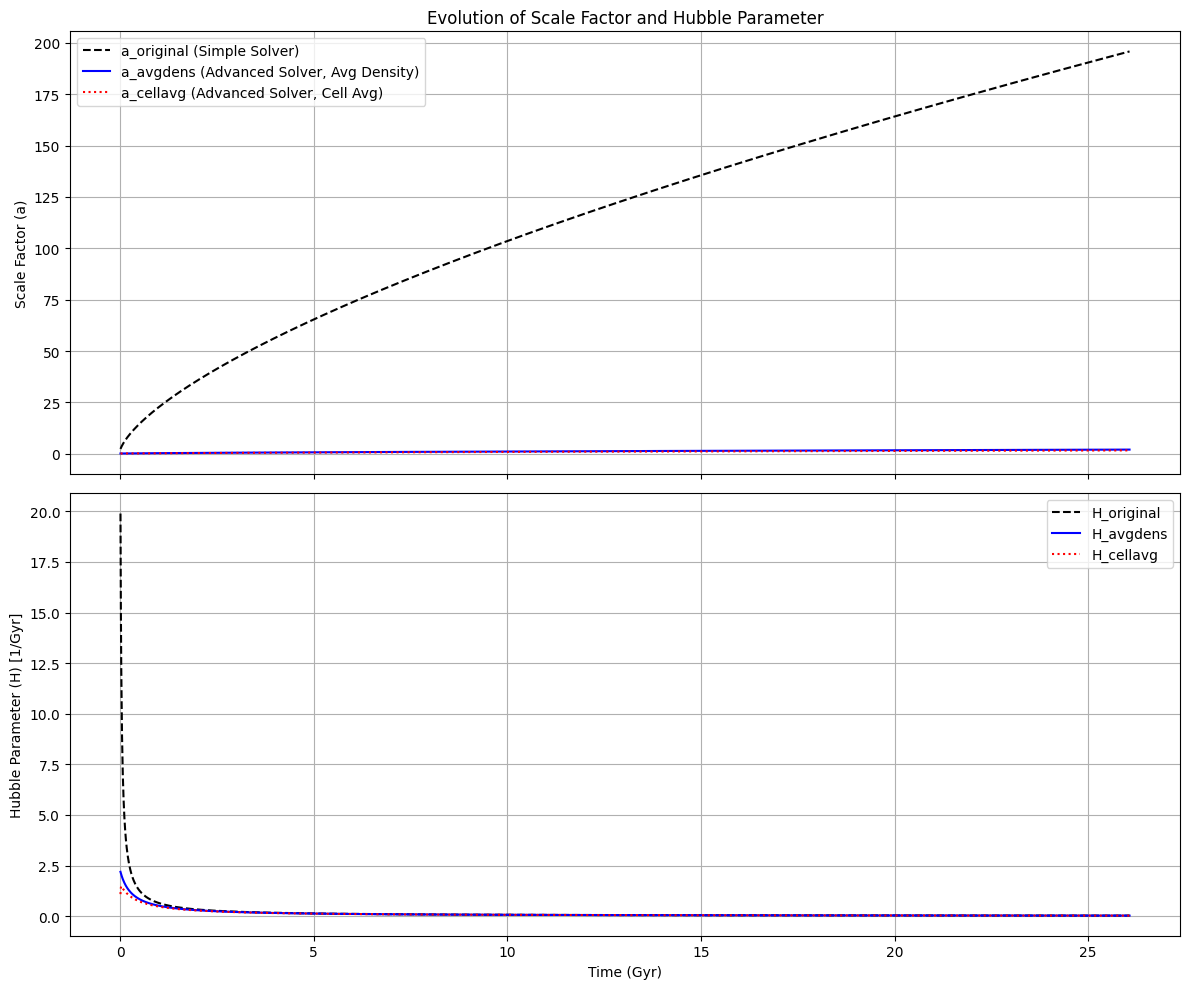

In [2]:

if 'cft' in sys.modules and not isinstance(cft, type):
    import cft

N = 64  # Reduced for faster execution
B_m = cft.Box(2, N, 50.0)

A = 10
seed = 4
# Ensure these functions from cft are available
try:
    Power_spectrum = cft.Power_law(-0.5) * cft.Scale(B_m, 0.2) * cft.Cutoff(B_m)
    phi = cft.garfield(B_m, Power_spectrum, cft.Potential(), seed) * A
except (NameError, AttributeError):
    print("Using dummy power spectrum and field due to missing 'cft' functions.")
    k = np.linalg.norm(B_m.K, axis=0)
    Power_spectrum = np.exp(-k**2 / (2 * (0.2 * 2 * np.pi / B_m.L)**2))
    Power_spectrum[k==0] = 0
    phi = np.fft.ifftn(np.sqrt(Power_spectrum) * (np.random.randn(*B_m.shape) + 1j * np.random.randn(*B_m.shape))).real * A


force_box = cft.Box(2, N*2, B_m.L)

# Use a cosmology with dark energy for a more interesting evolution
cosmology_model = EdS # LCDM 

za = Zeldovich(B_m, force_box, cosmology_model, phi)

a_initial = 0.1 # Start at a later time
dt = 0.01 # Timestep in Gyr

state = za.state(a_initial)
system = PoissonVlasov(force_box, cosmology_model, za.particle_mass, dt)
system.initialize_cosmology(a_initial)

stepper = partial(leap_frog, dt, system)
final_state, history = iterate_step(stepper, lambda s: system.cosmology_avgdens['a'] > 2.0, state, system)

print("Simulation finished. Plotting results...")
plot_results(history)

In [3]:
history.keys()

dict_keys(['time', 'a_original', 'H_original', 'a_avgdens', 'H_avgdens', 'a_cellavg', 'H_cellavg'])

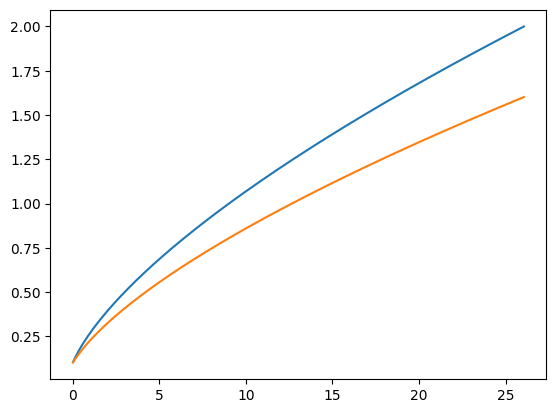

In [9]:
xend = 1
xstart = 1
#plt.loglog(history['time'][xstart:-xend], history['H_avgdens'][xstart:-xend])
#plt.loglog(history['time'][xstart:-xend], history['H_cellavg'][xstart:-xend])

plt.plot(history['time'][xstart:-xend], history['a_avgdens'][xstart:-xend])
plt.plot(history['time'][xstart:-xend], history['a_cellavg'][xstart:-xend])


#plt.plot(1/np.array(history['a_avgdens'][xstart:-xend])-1, history['H_avgdens'][xstart:-xend])
#plt.plot(1/np.array(history['a_cellavg'][xstart:-xend])-1, history['H_cellavg'][xstart:-xend])